In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import db


In [10]:
credentials = db.config()
conn = db.create_connection(credentials, dbname="parkrun")


**1. W których miastach odbywa się więcej niż jeden parkrun?**


In [40]:
multiple_events_location_sql = """
SELECT
  location,
  state,
  count(*)
FROM
  locations
GROUP BY
  location,
  state
HAVING
  count(*) > 1
ORDER BY
  count DESC;
"""

multiple_events_location_sql_df = pd.read_sql(multiple_events_location_sql, conn)
multiple_events_location_sql_df


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\3093212807.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  multiple_events_location_sql_df = pd.read_sql(multiple_events_location_sql, conn)


,location,state,count
0,Warszawa,mazowieckie,5
1,Poznań,wielkopolskie,3
2,Gdynia,pomorskie,2
3,Łódź,łódzkie,2
4,Kraków,małopolskie,2
5,Gdańsk,pomorskie,2


In [104]:
first_parkruns_sql = """
WITH first_events AS (
  SELECT
    date_part('year', date) :: int AS year
  FROM
    EVENTS e
    LEFT JOIN locations l ON e.location_id = l.id
  WHERE
    event_number = 1
)
SELECT
  year,
  count(*)
FROM
  first_events
GROUP BY
  year
"""

first_parkruns_sql_df = pd.read_sql(first_parkruns_sql, conn)


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\4025442386.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  first_parkruns_sql_df = pd.read_sql(first_parkruns_sql, conn)


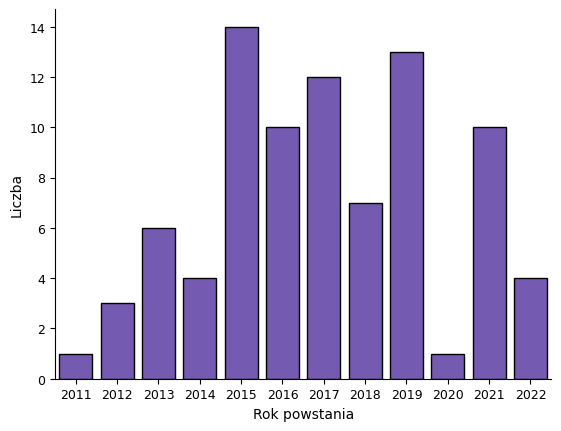

In [921]:
sns.barplot(
    data=first_parkruns_sql_df, x="year", y="count", color="#6e4bbf", edgecolor="black"
)
plt.ylabel("Liczba")
plt.xlabel("Rok powstania")
plt.tick_params(axis="both", which="major", labelsize=9)
sns.despine()
plt.savefig("year.png", dpi=100)
plt.show()


In [158]:
events_sql = """
SELECT 
    short_name, 
    event_number, 
    date
FROM events e
LEFT JOIN locations l
ON e.location_id = l.id
"""

events_sql_df = pd.read_sql(events_sql, conn, parse_dates=["date"])
events_sql_df


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\1525636457.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  events_sql_df = pd.read_sql(events_sql, conn, parse_dates=['date'])


,short_name,event_number,date
0,Gdynia,508,2022-12-26
1,Gdynia,507,2022-12-24
2,Gdynia,506,2022-12-17
3,Gdynia,505,2022-12-10
4,Gdynia,504,2022-12-03
...,...,...,...
19638,"Park Miejski, Sosnowiec",67,2022-12-31
19639,Park Nadnyski,56,2022-12-31
19640,Wzniesienie Osowy,41,2022-12-31
19641,Zielony Jar,17,2022-12-31


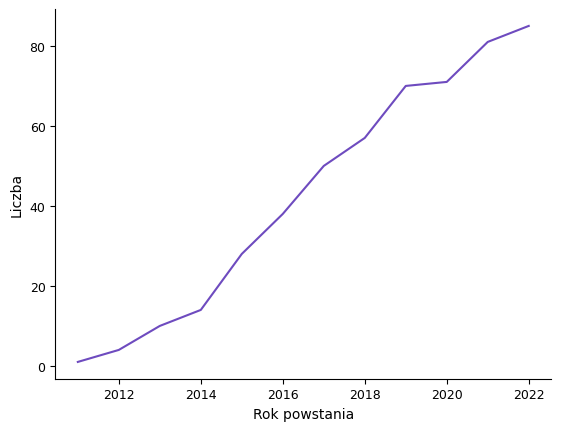

In [849]:
events_first = events_sql_df[events_sql_df["event_number"] == 1]
events_by_year = events_first.groupby(events_first.date.dt.year)["date"].count()

events_by_year.cumsum().plot(color="#6e4bbf")
plt.ylabel("Liczba")
plt.xlabel("Rok powstania")
plt.tick_params(axis="both", which="major", labelsize=9)
sns.despine()
plt.savefig("year_line.png", dpi=200, bbox_inches="tight")
plt.show()


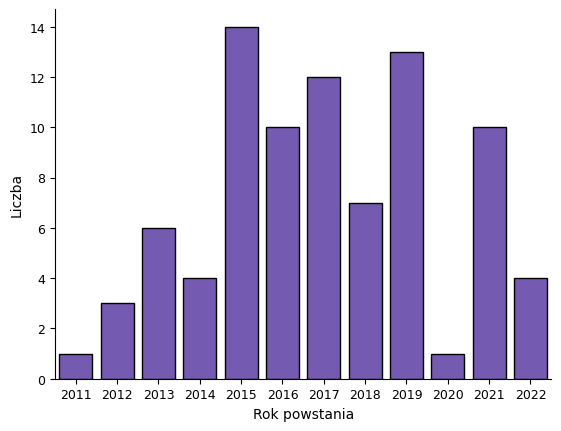

In [824]:
sns.reset_defaults()
sns.barplot(
    x=events_by_year.index, y=events_by_year.values, color="#6e4bbf", edgecolor="black"
)
plt.ylabel("Liczba")
plt.xlabel("Rok powstania")
plt.tick_params(axis="both", which="major", labelsize=9)
sns.despine()
plt.savefig("year.png", dpi=200, bbox_inches="tight")
plt.show()


In [226]:
top_locations_2022_sql = """
WITH events_2022 AS (
  SELECT
    location_id,
    location,
    short_name,
    date_part('year', date) AS year,
    participants
  FROM
    EVENTS e
    LEFT JOIN locations l ON e.location_id = l.id
  WHERE
    date_part('year', date) = 2022
),
events_2022_top_avg AS (
  SELECT
    location_id,
    location,
    short_name,
    avg(participants)
  FROM
    events_2022
  GROUP BY
    location_id,
    location,
    short_name
  ORDER BY
    avg DESC
  LIMIT
    10
)
SELECT
  short_name,
  date,
  participants
FROM
  EVENTS e
  LEFT JOIN locations l ON e.location_id = l.id
WHERE
  date_part('year', date) = 2022
  AND location_id IN (
    SELECT
      location_id
    FROM
      events_2022_top_avg
  )
"""


top_locations_2022_sql_df = pd.read_sql(top_locations_2022_sql, conn)
top_locations_2022_sql_df


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\2328099692.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_locations_2022_sql_df = pd.read_sql(top_locations_2022_sql, conn)


,short_name,date,participants
0,Gdynia,2022-12-26,54
1,Gdynia,2022-12-24,81
2,Gdynia,2022-12-17,66
3,Gdynia,2022-12-10,72
4,Gdynia,2022-12-03,73
...,...,...,...
523,Chrzanów,2022-12-31,124
524,Toruń,2022-12-31,161
525,Tczew,2022-12-31,247
526,Gorzów Wielkopolski,2022-12-31,98


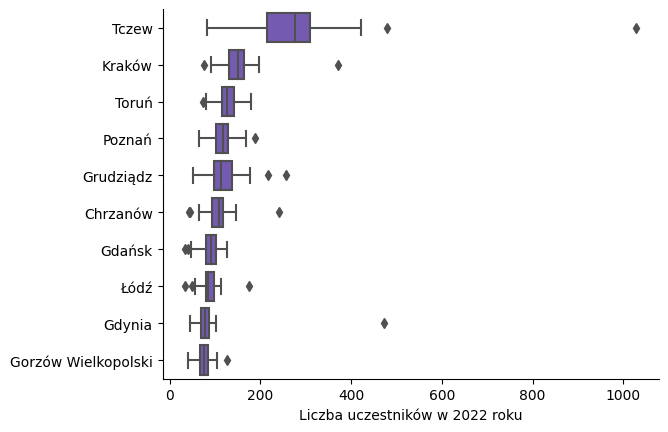

In [866]:
import numpy as np

order = (
    top_locations_2022_sql_df.groupby(["short_name"])["participants"]
    .aggregate(np.mean)
    .reset_index()
    .sort_values("participants", ascending=False)
)

sns.boxplot(
    data=top_locations_2022_sql_df,
    x="participants",
    y="short_name",
    order=order["short_name"],
    color="#6e4bbf",
)
plt.xlabel("Liczba uczestników w 2022 roku")
plt.ylabel(None)
sns.despine()
plt.savefig("top_locations_2022.png", dpi=200, bbox_inches="tight")
plt.show()


In [876]:
y2y_change_sql = """
WITH events_2021 AS (
  SELECT
    location,
    short_name,
    PERCENTILE_DISC(0.5) WITHIN GROUP(
      ORDER BY
        participants
    ) AS median_2021
  FROM
    (
      SELECT
        *
      FROM
        EVENTS e
        LEFT JOIN locations l ON e.location_id = l.id
      WHERE
        date_part('year', date) = 2021
    ) a
  GROUP BY
    location,
    short_name
),
events_2022 AS (
  SELECT
    location,
    short_name,
    round(
      PERCENTILE_DISC(0.5) WITHIN GROUP(
        ORDER BY
          participants
      ),
      1
    ) AS median_2022
  FROM
    (
      SELECT
        *
      FROM
        EVENTS e
        LEFT JOIN locations l ON e.location_id = l.id
      WHERE
        date_part('year', date) = 2022
    ) a
  GROUP BY
    location,
    short_name
),
events_joined AS (
  SELECT
    *
  FROM
    events_2021 e1
    LEFT JOIN events_2022 e2 USING(location, short_name)
)
SELECT
  CASE
    WHEN location = short_name THEN location
    ELSE location || ' (' || short_name || ')'
  END AS location,
  median_2021,
  median_2022,
  round(((median_2022 / median_2021) -1) * 100, 1) AS pct_change
FROM
  events_joined
ORDER BY
  pct_change DESC;
"""

y2y_change_sql_df = pd.read_sql(y2y_change_sql, conn)
y2y_change_sql_df


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\172451561.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  y2y_change_sql_df = pd.read_sql(y2y_change_sql, conn)


,location,median_2021,median_2022,pct_change
0,Kościerzyna (Rezerwat Strzelnica),21,39.0,85.7
1,Żyrardów (Zalew Żyrardowski),9,16.0,77.8
2,Częstochowa (Las Aniołowski),24,42.0,75.0
3,Grudziądz,70,113.0,61.4
4,Malbork (Zamek w Malborku),14,22.0,57.1
...,...,...,...,...
76,Poznań,141,117.0,-17.0
77,Opole,27,22.0,-18.5
78,gmina Dopiewo (Dąbrówka),54,44.0,-18.5
79,"Kudowa-Zdrój (Park Zdrojowy, Kudowa-Zdrój)",12,9.0,-25.0


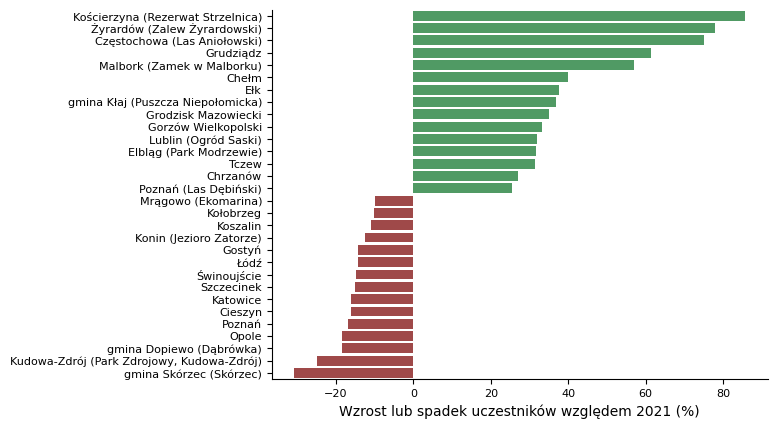

In [879]:
y2y_change_top = pd.concat([y2y_change_sql_df.head(15), y2y_change_sql_df.tail(15)])

sns.barplot(
    data=y2y_change_top,
    y="location",
    x="pct_change",
    palette=[
        "#44a65e" if pct >= 0 else "#ad3b3b" for pct in y2y_change_top["pct_change"]
    ],
)
plt.ylabel(None)
plt.xlabel("Wzrost lub spadek uczestników względem 2021 (%)")
plt.tick_params(axis="both", which="major", labelsize=8)
sns.despine()
plt.savefig("pct_change.png", dpi=300, bbox_inches="tight")
plt.show()


In [882]:
best_avg_results_per_year_sql = """
SELECT
  date_part('year', date) :: int AS year,
  round(avg(best_male_time), 0) :: int AS M,
  round(avg(best_female_time), 0) :: int AS K
FROM
  EVENTS
GROUP BY
  year
ORDER BY
  YEAR;
"""

best_avg_results_per_year_sql_df = pd.read_sql(best_avg_results_per_year_sql, conn)
best_avg_results_per_year_sql_df


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\502127251.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  best_avg_results_per_year_sql_df = pd.read_sql(best_avg_results_per_year_sql, conn)


,year,m,k
0,2011,1299,1559
1,2012,1106,1370
2,2013,1084,1364
3,2014,1082,1353
4,2015,1114,1392
5,2016,1121,1383
6,2017,1140,1404
7,2018,1151,1434
8,2019,1157,1446
9,2020,1154,1439


In [884]:
best_avg_results_long = pd.melt(
    best_avg_results_per_year_sql_df,
    id_vars="year",
    value_vars=["m", "k"],
    value_name="avg_winner_time",
)


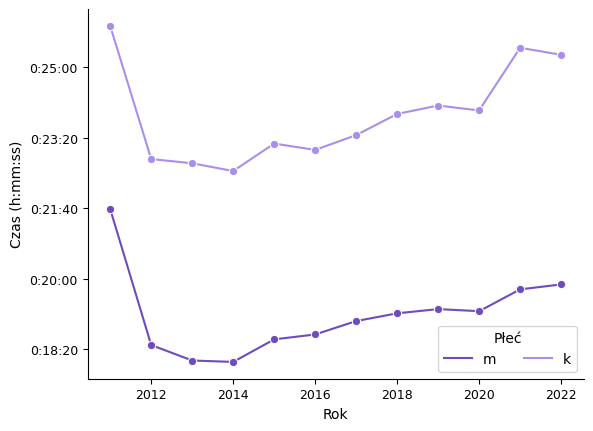

In [895]:
from matplotlib.ticker import FuncFormatter
from datetime import timedelta

best_avg_results_long = pd.melt(
    best_avg_results_per_year_sql_df,
    id_vars="year",
    value_vars=["m", "k"],
    value_name="avg_winner_time",
)

g = sns.lineplot(
    data=best_avg_results_long,
    x="year",
    y="avg_winner_time",
    hue="variable",
    marker="o",
    palette=["#6e4bbf", "#a98feb"],
)

g.yaxis.set_major_formatter(FuncFormatter(lambda x, y: str(timedelta(seconds=x))))
plt.ylabel("Czas (h:mm:ss)")
plt.xlabel("Rok")
plt.legend(title="Płeć", loc="best", ncol=2)
plt.tick_params(axis="both", which="major", labelsize=9)
sns.despine()
plt.savefig("fastest_years.png", dpi=200, bbox_inches="tight")
plt.show()


In [496]:
res_male_2022_sql = """
WITH top_avg_2022 AS (
  SELECT
    location_id,
    avg(best_male_time)
  FROM
    (
      SELECT
        *
      FROM
        EVENTS e
        LEFT JOIN locations l ON e.location_id = l.id
      WHERE
        date_part('year', date) = 2022
    ) a
  GROUP BY
    location_id
  ORDER BY
    avg
  LIMIT
    15
)
SELECT
  date_part('year', date) AS year,
  CASE
    WHEN location = short_name THEN location
    ELSE location || ' (' || short_name || ')'
  END AS location,
  best_male_time
FROM
  EVENTS e
  LEFT JOIN locations l ON e.location_id = l.id
WHERE
  date_part('year', date) = 2022
  AND location_id IN (
    SELECT
      location_id
    FROM
      top_avg_2022
  )
"""

res_male_2022 = pd.read_sql(res_male_2022_sql, conn)
res_male_2022


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\426978049.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  res_male_2022 = pd.read_sql(res_male_2022_sql, conn)


,year,location,best_male_time
0,2022.0,Gdynia,1110
1,2022.0,Gdynia,1120
2,2022.0,Gdynia,1160
3,2022.0,Gdynia,1185
4,2022.0,Gdynia,1151
...,...,...,...
789,2022.0,Toruń,1124
790,2022.0,Szczecin,1106
791,2022.0,Tczew,1078
792,2022.0,Gdańsk (Gdańsk-Południe),1026


In [494]:
order = (
    res_male_2022.groupby(["location"])["best_male_time"]
    .aggregate(np.median)
    .reset_index()
    .sort_values("best_male_time", ascending=True)
)


,location,best_male_time
4,Kraków,1009.0
10,Warszawa (Warszawa-Praga),1042.0
1,Gdańsk,1064.0
5,Poznań,1071.0
13,Wrocław,1072.0
6,Poznań (Lasek Marceliński),1084.0
12,Warszawa (Warszawa-Żoliborz),1087.0
11,Warszawa (Warszawa-Ursynów),1095.0
8,Tczew,1096.0
2,Gdańsk (Gdańsk-Południe),1096.5


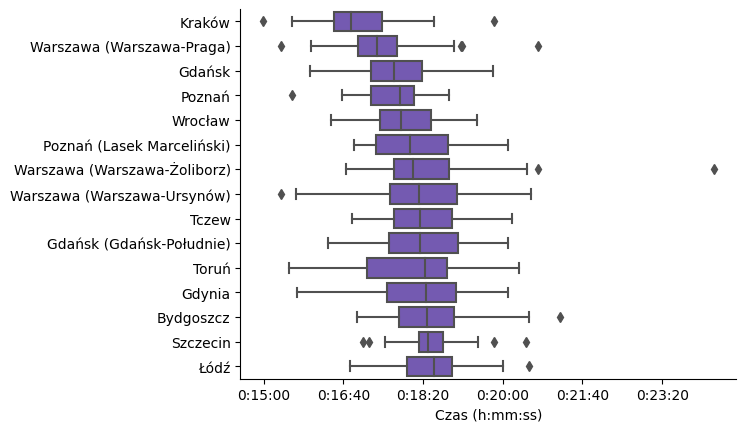

In [900]:
order = (
    res_male_2022.groupby(["location"])["best_male_time"]
    .aggregate(np.median)
    .reset_index()
    .sort_values("best_male_time", ascending=True)
)


g = sns.boxplot(
    data=res_male_2022,
    x="best_male_time",
    y="location",
    order=order["location"],
    color="#6e4bbf",
)
g.xaxis.set_major_formatter(FuncFormatter(lambda x, y: str(timedelta(seconds=x))))
plt.ylabel(None)
plt.xlabel("Czas (h:mm:ss)")
sns.despine()
plt.savefig("fastest_city_by_male.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\1202262226.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  res_female_2022 = pd.read_sql(res_female_2022_sql, conn)


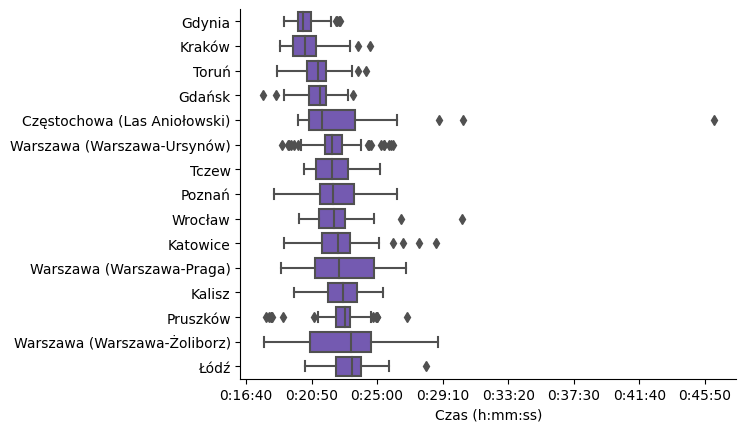

In [901]:
res_female_2022_sql = """
WITH top_avg_2022 AS (
    SELECT 
      location_id, avg(best_female_time)
    FROM (
      SELECT 
        *
      FROM events e 
      LEFT JOIN locations l 
      ON e.location_id = l.id
      WHERE date_part('year', date) = 2022
    ) a
    GROUP BY location_id
    ORDER BY avg
    LIMIT 15
)
SELECT 
date_part('year', date) as year, 
case when location = short_name then location else location || ' (' || short_name || ')' end as location, 
best_female_time
FROM events e
LEFT JOIN locations l
ON e.location_id = l.id
WHERE date_part('year', date) = 2022 AND location_id IN (SELECT location_id from top_avg_2022)
"""

res_female_2022 = pd.read_sql(res_female_2022_sql, conn)


order3 = (
    res_female_2022.groupby(["location"])["best_female_time"]
    .aggregate(np.median)
    .reset_index()
    .sort_values("best_female_time", ascending=True)
)
g = sns.boxplot(
    data=res_female_2022,
    x="best_female_time",
    y="location",
    order=order3["location"],
    color="#6e4bbf",
)
g.xaxis.set_major_formatter(FuncFormatter(lambda x, y: str(timedelta(seconds=x))))
plt.ylabel(None)
plt.xlabel("Czas (h:mm:ss)")
sns.despine()
plt.savefig("fastest_city_by_female.png", dpi=300, bbox_inches="tight")
plt.show()


In [910]:
results = pd.read_sql("SELECT * FROM results", conn)


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\2016569637.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results = pd.read_sql("SELECT * FROM results", conn)


In [913]:
results["group"] = results["agegroup"].apply(lambda x: x[2:])
results = results[
    (results["group"] != "---")
    & (results["group"] != "")
    & (results["group"] != "zestnik na wózku (M)")
    & (results["time"] <= 3600)
]


array(['25-29', '35-39', '40-44', '45-49', '50-54', '11-14', '30-34',
       '70-74', '10', '65-69', '60-64', '80-84', '55-59', '20-24',
       '15-17', '18-19', '75-79', '85-89', '90-94'], dtype=object)

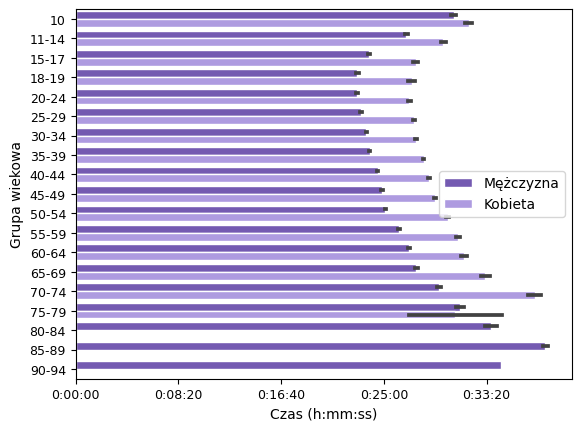

In [906]:
g = sns.barplot(
    data=results,
    y="group",
    x="time",
    hue="gender",
    order=sorted(results["group"].unique()),
    palette=["#6e4bbf", "#a98feb"],
    edgecolor="w",
)
g.xaxis.set_major_formatter(FuncFormatter(lambda x, y: str(timedelta(seconds=x))))
plt.tick_params(axis="both", which="major", labelsize=9)
plt.ylabel("Grupa wiekowa")
plt.xlabel("Czas (h:mm:ss)")
plt.legend(title=None)
plt.savefig("results_by_age_group.png", dpi=300, bbox_inches="tight")
plt.show()


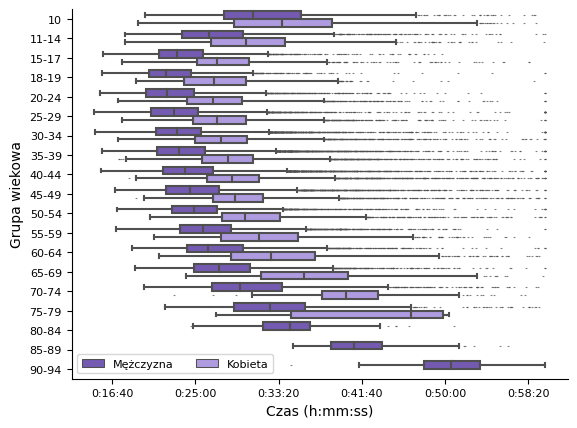

In [914]:
g = sns.boxplot(
    data=results,
    y="group",
    x="time",
    hue="gender",
    order=sorted(list(results["group"].unique())),
    palette=["#6e4bbf", "#a98feb"],
    fliersize=0.2,
)
g.xaxis.set_major_formatter(FuncFormatter(lambda x, y: str(timedelta(seconds=x))))
plt.tick_params(axis="both", which="major", labelsize=8)
plt.ylabel("Grupa wiekowa")
plt.xlabel("Czas (h:mm:ss)")
plt.legend(title=None, loc="lower left", ncols=2, fontsize=8)
sns.despine()
plt.savefig("results_by_age_group.png", dpi=300, bbox_inches="tight")
plt.show()


In [917]:
results = pd.read_sql(
    "SELECT * FROM results r LEFT join events e on r.event_id = e.id LEFT JOIN locations l ON e.location_id = l.id",
    conn,
    parse_dates=["date"],
)


C:\Users\bartl\AppData\Local\Temp\ipykernel_6596\2115209314.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results = pd.read_sql("SELECT * FROM results r LEFT join events e on r.event_id = e.id LEFT JOIN locations l ON e.location_id = l.id", conn, parse_dates=['date'])


In [742]:
results.head()


,id,position,gender,agegroup,time,time_str,achievement,event_id,id,event_number,...,best_female_time_str,location_id,id,name,short_name,latitude,longitude,state,location,month
0,1,1,Mężczyzna,SM25-29,1110,18:30,,1,1,508,...,21:10,1,1,gdynia,Gdynia,54.502632,18.558699,pomorskie,Gdynia,4
1,2,2,Mężczyzna,VM35-39,1112,18:32,Debiutant,1,1,508,...,21:10,1,1,gdynia,Gdynia,54.502632,18.558699,pomorskie,Gdynia,4
2,3,3,Mężczyzna,VM40-44,1175,19:35,,1,1,508,...,21:10,1,1,gdynia,Gdynia,54.502632,18.558699,pomorskie,Gdynia,4
3,4,4,Mężczyzna,VM40-44,1212,20:12,,1,1,508,...,21:10,1,1,gdynia,Gdynia,54.502632,18.558699,pomorskie,Gdynia,4
4,5,5,Mężczyzna,VM45-49,1222,20:22,,1,1,508,...,21:10,1,1,gdynia,Gdynia,54.502632,18.558699,pomorskie,Gdynia,4


In [918]:
results = results[results["time"] < 45 * 60]
ridge_order = (
    results.groupby("short_name")["time"]
    .aggregate(np.mean)
    .reset_index()
    .sort_values(by="time")
)
ridge_order


,short_name,time
1,Gdynia,1519.873390
0,Gdańsk,1526.812022
2,Kraków,1531.520546
3,Poznań,1556.803658
4,Łódź,1558.453194


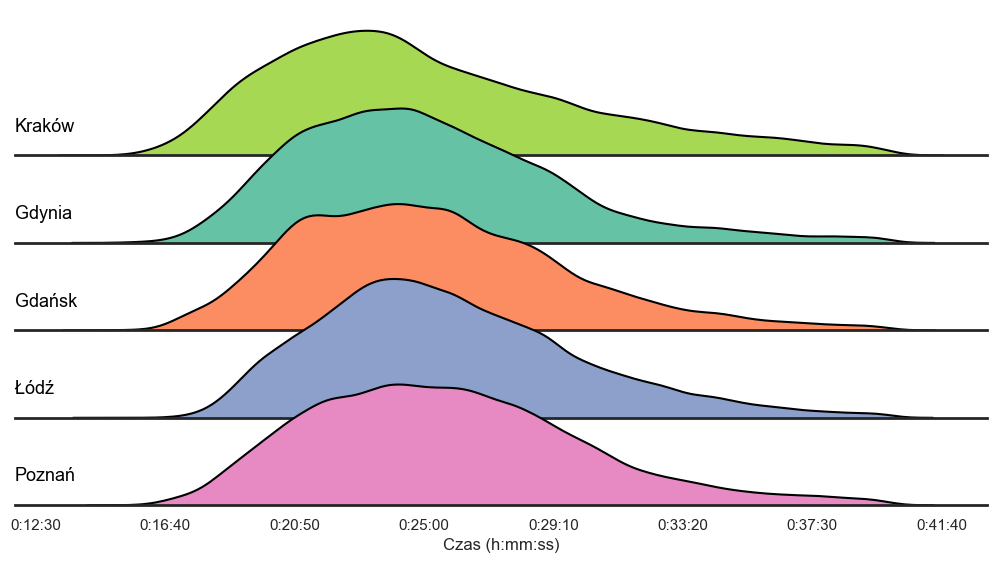

In [920]:
results = results[results["time"] < 40 * 60]
ridge_order = (
    results.groupby("short_name")["time"]
    .aggregate(np.median)
    .reset_index()
    .sort_values(by="time")
)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.linewidth": 2})
palette = sns.color_palette("Set2", 12)

g = sns.FacetGrid(
    results,
    palette=palette,
    row="short_name",
    hue="short_name",
    aspect=9,
    height=1.2,
    row_order=ridge_order["short_name"],
)

g.map_dataframe(sns.kdeplot, x="time", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="time", color="black")

def label(x, color, label):
    ax = plt.gca() 
    ax.text(
        0,
        0.2,
        label,
        color="black",
        fontsize=13,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label, "short_name")
g.fig.subplots_adjust(hspace=-0.4)
g.set_titles("")
g.set_ylabels(None)
g.set_xlabels(None)
g.set(yticks=[], xlabel="Czas (h:mm:ss)")

for ax in g.axes[0]:
    x_axis = ax.get_xaxis()
    x_axis.set_major_formatter(FuncFormatter(lambda x, y: str(timedelta(seconds=x))))

g.despine(left=True)
plt.savefig("kdeplot.png", dpi=300, bbox_inches="tight")
plt.show()
